In [42]:
import imageio
import torch
from IPython.display import clear_output
import matplotlib.pyplot as plt


In [40]:
#Load gif: 
img = imageio.mimread('data/1kWp.gif')

In [65]:
img[0][0]

Array([[197, 197, 195, ..., 197, 195, 197],
       [197, 195, 195, ..., 195, 195, 197],
       [195, 197, 195, ..., 195, 197, 195],
       ...,
       [191, 184, 191, ..., 191, 184, 191],
       [184, 184, 191, ..., 184, 191, 184],
       [191, 184, 184, ..., 181, 191, 181]], dtype=uint8)

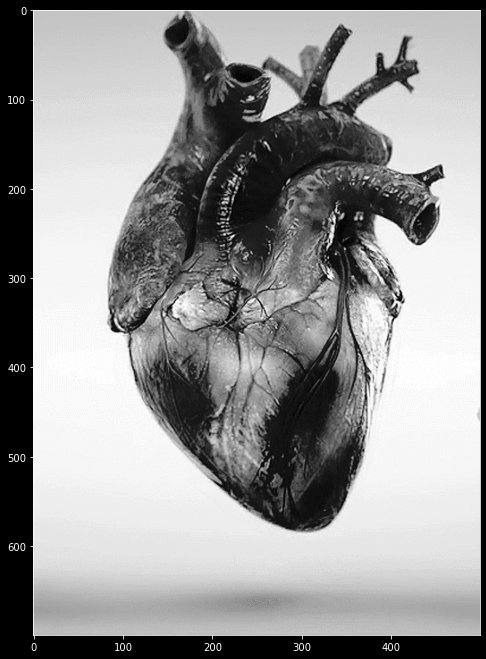

In [73]:
for i in range(len(img)):
    clear_output(wait=True)
    plt.figure(figsize=(8,12))
    plt.imshow(img[i],cmap='gray')
    plt.show()

In [66]:
import cv2

In [74]:
for i in range(len(img)):
    pass

img_resize = cv2.resize(img[0],dsize=(100,100))
type(img_resize)

TypeError: 'list' object cannot be interpreted as an integer